This script plots the domain of the Desert Southwest and the domain of the Colorado Plateau.

In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar
import importlib

# math and data
import math
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import scipy.linalg
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
misc_data_path = '/glade/u/home/zcleveland/scratch/misc_data/'  # path to misc data
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated plots
scripts_main_path = '/glade/u/home/zcleveland/NAM_soil-moisture/scripts_main/'  # path to my dicts, lists, and functions
invariant_path = '/glade/u/home/zcleveland/scratch/ERA5/invariants/'  # path to invariant variables

# import variable lists and dictionaries
if scripts_main_path not in sys.path:
    sys.path.insert(0, scripts_main_path)  # path to file containing these lists/dicts
if 'get_var_data' in sys.modules:
    importlib.reload(sys.modules['get_var_data'])
if 'my_functions' in sys.modules:
    importlib.reload(sys.modules['my_functions'])
if 'my_dictionaries' in sys.modules:
    importlib.reload(sys.modules['my_dictionaries'])
if 'order_years' in sys.modules:
    importlib.reload(sys.modules['order_years'])

# import common functions that I've created
from get_var_data import get_var_data, get_var_files, open_var_data, subset_var_data, time_to_year_month_avg, time_to_year_month_sum, time_to_year_month
from my_functions import month_num_to_name, ensure_var_list, plot_region_boundaries
from order_years import *  # order_years(var, months, **kwargs)

# import lists and dictionaries
from my_dictionaries import (
sfc_instan_list, sfc_accumu_list, pl_var_list, derived_var_list, invar_var_list,
NAM_var_list, region_avg_list, flux_var_list, vector_var_list, misc_var_list,
var_dict, var_units, region_avg_dict, region_avg_coords, region_colors_dict
)

In [2]:
# define a function to plot the boundaries for the domains
def plot_domain(region_coords, names, colors, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-130, -90, 10, 50], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.STATES, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.set_facecolor('lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.25)

    # draw the red box for "Desert Southwest"
    desert_sw_box = {
        'lon': [240, 260, 260, 240, 240],
        'lat': [20, 20, 40, 40, 20]
    }
    ax.plot(desert_sw_box['lon'], desert_sw_box['lat'], color='black', linewidth=2, transform=ccrs.PlateCarree())
    ax.text(241, 40.5, 'Desert Southwest', color='black', fontsize=20, weight='bold', transform=ccrs.PlateCarree())

    # plot regions
    for region, coords in region_coords.items():
        lon = [coords[0], coords[1], coords[1], coords[0], coords[0]]
        lat = [coords[2], coords[2], coords[3], coords[3], coords[2]]
        ax.plot(lon, lat, color=colors[region], linewidth=2, transform=ccrs.PlateCarree())

    # Plot the legend in the lower left corner
    for i, (region, name) in enumerate(names.items()):
        if i<=3:
            plt.text(-129, 15 - i * 2, f"{name}", color=colors[region], fontsize=15, weight='bold')
        elif i>3:
            plt.text(-109, 21 - i * 2, f"{name}", color=colors[region], fontsize=15, weight='bold')

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = True
    gl.right_labels = True
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = plt.FixedLocator(range(-130, -89, 5))
    gl.ylocator = plt.FixedLocator(range(10, 51, 5))

    # fig.subplots_adjust(top=0.9)
    # fig.suptitle('Study Domain')

    # plt.savefig(f'{plot_out_path}study_domain_regions.png', dpi=300, bbox_inches='tight')
    plt.show()

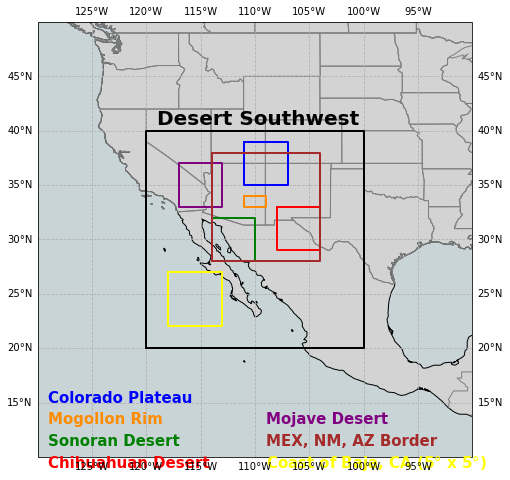

In [3]:
plot_domain(region_avg_coords, region_avg_dict, region_colors_dict)

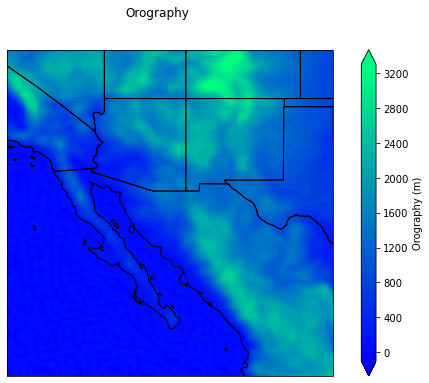

In [51]:
# plot the orography over the domain
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ds = xr.open_dataset(os.path.join(invariant_path, 'elevation_invariant.nc'))
da = ds['Z'].sel(latitude=slice(40,20), longitude=slice(240,260), drop=True)

vmin = round(int(da.min().values), -2)
vmax = round(int(da.max().values), -2)
levels = np.arange(vmin, vmax, 100)
cf = plt.contourf(da.longitude, da.latitude, da,
                  levels=levels, cmap = 'winter', extend='both')
plt.colorbar(cf, ax=ax, label='Orography (m)')

# add map features
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

fig.suptitle('Orography')

# plt.savefig(f'{plot_out_path}elevation.png', dpi=1000, bbox_inches='tight')
plt.show()